#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz
from IPython.display import display

#### Load and Analyze the Dataset

In [2]:
df = pd.read_csv('../../dataset/decision-tree.csv')
print(df.shape) 

(768, 9)


In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [5]:
# Checking if any of the columns have NaN values 
flag = 0
for column in df.columns:
    if any(df[column].isna()):
        print(column, " ------ NaN exists")
        flag = 1
        
if(flag == 0):
    print("NaN doesn't exist")

NaN doesn't exist


In [6]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1,1)

# Performing the Min-Max Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X

array([[0.35294118, 0.74371859, 0.59016393, ..., 0.50074516, 0.23441503,
        0.48333333],
       [0.05882353, 0.42713568, 0.54098361, ..., 0.39642325, 0.11656704,
        0.16666667],
       [0.47058824, 0.91959799, 0.52459016, ..., 0.34724292, 0.25362938,
        0.18333333],
       ...,
       [0.29411765, 0.6080402 , 0.59016393, ..., 0.390462  , 0.07130658,
        0.15      ],
       [0.05882353, 0.63316583, 0.49180328, ..., 0.4485842 , 0.11571307,
        0.43333333],
       [0.05882353, 0.46733668, 0.57377049, ..., 0.45305514, 0.10119556,
        0.03333333]])

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=41)

In [8]:
feature_names = df.columns # extracting column names

In [9]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

#### Decision Tree Classifier from Scratch

In [10]:
class Node():
    
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        
        # for decision nodes (internal nodes)
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf nodes
        self.value = value

In [11]:
class DecisionTreeClassifier():
    
    def __init__(self, min_samples_split=2, max_depth=2, min_info_gain=0.01):
        
        # initialization 
        self.root = None
        
        # stopping conditions or preprunning
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.min_info_gain = min_info_gain 
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            
            if best_split["info_gain"]>0 and best_split["info_gain"] > self.min_info_gain:
                
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # leaf node
        leaf_value = self.calculate_leaf_value(Y)
        
        # return leaf node
        return Node(value=leaf_value)
    
    #function to get best split
    def get_best_split(self, dataset, num_samples, num_features):
        
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # loop over feature values
            for threshold in possible_thresholds:
                
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                # check if blank child nodes
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    
                    # calculate information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    # function splitting the nodes
    def split(self, dataset, feature_index, threshold):
        dataset_left = dataset[dataset[:, feature_index] <= threshold]
        dataset_right = dataset[dataset[:, feature_index] > threshold]
        
        return dataset_left, dataset_right
    
    # function computing information gain of a split
    def information_gain(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))

        return gain
    
    #function to calculate entropy of a node
    def entropy(self, y):
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    # function to compute majority class    
    def calculate_leaf_value(self, Y):
        value_counts = {}
        max_count = 0
        most_common_value = None

        for value in Y:
            if value in value_counts:
                value_counts[value] += 1
            else:
                value_counts[value] = 1

            if value_counts[value] > max_count:
                max_count = value_counts[value]
                most_common_value = value

        return most_common_value

    # function to fit the model
    def fit(self, X, Y, validation_data=None):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
        if validation_data is not None:
            val_X, val_Y = validation_data
            val_dataset = np.concatenate((val_X, val_Y), axis=1)
            self.root = self.prune_tree(self.root, val_dataset)
        
    # predict function
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    # function returning predictions for individual values
    def make_prediction(self, x, tree):
        if tree.value != None: 
            return tree.value
        
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            next_tree = tree.left
        else:
            next_tree = tree.right
            
        return self.make_prediction(x, next_tree)

    # Reduced Error Pruning (Post Pruning)
    def prune_tree(self, tree, dataset):
        if tree is None:
            return None
        
        if tree.left is None and tree.right is None:
            return tree

        tree.left = self.prune_tree(tree.left, dataset)
        tree.right = self.prune_tree(tree.right, dataset)

        # Calculate accuracy before pruning
        predictions = self.predict(dataset[:,:-1])
        actual_labels = dataset[:,-1]
        accuracy_before = np.mean(predictions == actual_labels)

        # Calculate accuracy after pruning
        temp_left = tree.left
        temp_right = tree.right
        tree.left = None
        tree.right = None
        tree.value = self.calculate_leaf_value(dataset[:,-1])
        predictions = self.predict(dataset[:,:-1])
        accuracy_after = np.mean(predictions == actual_labels)

        # Compare accuracies and decide whether to prune
        if accuracy_after >= accuracy_before:
            return tree
        else:
            tree.value = None
            tree.left = temp_left
            tree.right = temp_right
            return tree


In [12]:
# functions to print the tree
def build_tree_dot(node, dot_data, feature_names, parent_id=None, edge_label=None):
    if node.value is not None:
        label = f"Class {node.value}"
        color = "green"  # Color for leaf nodes
    else:
        label = f"{feature_names[node.feature_index]}\n Threshold <= {node.threshold:.2f}\n Info_gain = {node.info_gain:.2f}"
        color = "blue"  # Color for non-leaf nodes

    shape = "box" if node.value is not None else "ellipse"

    current_id = len(dot_data)
    dot_data.append(f'{current_id} [label="{label}", shape="{shape}", color="{color}"]')

    if parent_id is not None:
        dot_data.append(f'{parent_id} -> {current_id} [label="{edge_label}"]')

    if node.left is not None:
        build_tree_dot(node.left, dot_data, feature_names, parent_id=current_id, edge_label="True")

    if node.right is not None:
        build_tree_dot(node.right, dot_data, feature_names, parent_id=current_id, edge_label="False")

def export_tree_to_dot(tree, feature_names):
    dot_data = ['digraph Tree {']
    build_tree_dot(tree, dot_data, feature_names)
    dot_data.append('}')
    return '\n'.join(dot_data)

#### Evaluation metrics

In [13]:
def mean_macro_accuracy(y_true, y_pred):
    unique_classes = np.unique(y_true)
    class_accuracies = []

    for class_ in unique_classes:
        class_indices = [i for i, label in enumerate(y_true) if label == class_]
        class_true = [y_true[i] for i in class_indices]
        class_pred = [y_pred[i] for i in class_indices]
        class_accuracy = accuracy_score(class_true, class_pred)
        class_accuracies.append(class_accuracy)

    mean_macro_acc = sum(class_accuracies) / len(class_accuracies)
    return mean_macro_acc

def macro_precision(y_true, y_pred):
    unique_classes = np.unique(y_true)
    precision_scores = []

    for class_ in unique_classes:
        class_indices = [i for i, label in enumerate(y_true) if label == class_]
        class_true = [y_true[i] for i in class_indices]
        class_pred = [y_pred[i] for i in class_indices]
        class_precision = precision_score(class_true, class_pred)
        precision_scores.append(class_precision)

    macro_prec = sum(precision_scores) / len(precision_scores)
    return macro_prec

def macro_recall(y_true, y_pred):
    unique_classes = np.unique(y_true)
    recall_scores = []

    for class_ in unique_classes:
        class_indices = [i for i, label in enumerate(y_true) if label == class_]
        class_true = [y_true[i] for i in class_indices]
        class_pred = [y_pred[i] for i in class_indices]
        class_recall = recall_score(class_true, class_pred, zero_division=1)
        recall_scores.append(class_recall)

    macro_rec = sum(recall_scores) / len(recall_scores)
    return macro_rec

#### Decision Tree without Reduced Error Pruning

In [14]:
classifier = DecisionTreeClassifier(min_samples_split=10, max_depth=5)
classifier.fit(X_train,Y_train)

In [15]:
Y_pred = classifier.predict(X_test) 
print("Mean macro accuracy : ", mean_macro_accuracy(Y_test, Y_pred))
print("Macro precision : ", macro_precision(Y_test, Y_pred))
print("Macro recall : ", macro_recall(Y_test, Y_pred))
print()
print("Accuracy : ", accuracy_score(Y_test, Y_pred))
print("Precision : ", precision_score(Y_test, Y_pred))
print("Recall : ", recall_score(Y_test, Y_pred))

Mean macro accuracy :  0.703030303030303
Macro precision :  0.5
Macro recall :  0.7636363636363637

Accuracy :  0.7532467532467533
Precision :  0.7073170731707317
Recall :  0.5272727272727272


#### Decision Tree with Reduced Error Pruning

In [16]:
classifier_prune = DecisionTreeClassifier(min_samples_split=10, max_depth=5)
classifier_prune.fit(X_train,Y_train, validation_data=(X_train, Y_train))

In [17]:
Y_pred_prune = classifier_prune.predict(X_test) 
print("Mean macro accuracy : ", mean_macro_accuracy(Y_test, Y_pred_prune))
print("Macro precision : ", macro_precision(Y_test, Y_pred_prune))
print("Macro recall : ", macro_recall(Y_test, Y_pred_prune))
print()
print("Accuracy : ", accuracy_score(Y_test, Y_pred_prune))
print("Precision : ", precision_score(Y_test, Y_pred_prune))
print("Recall : ", recall_score(Y_test, Y_pred_prune))

Mean macro accuracy :  0.703030303030303
Macro precision :  0.5
Macro recall :  0.7636363636363637

Accuracy :  0.7532467532467533
Precision :  0.7073170731707317
Recall :  0.5272727272727272


#### Printing the tree using graphviz

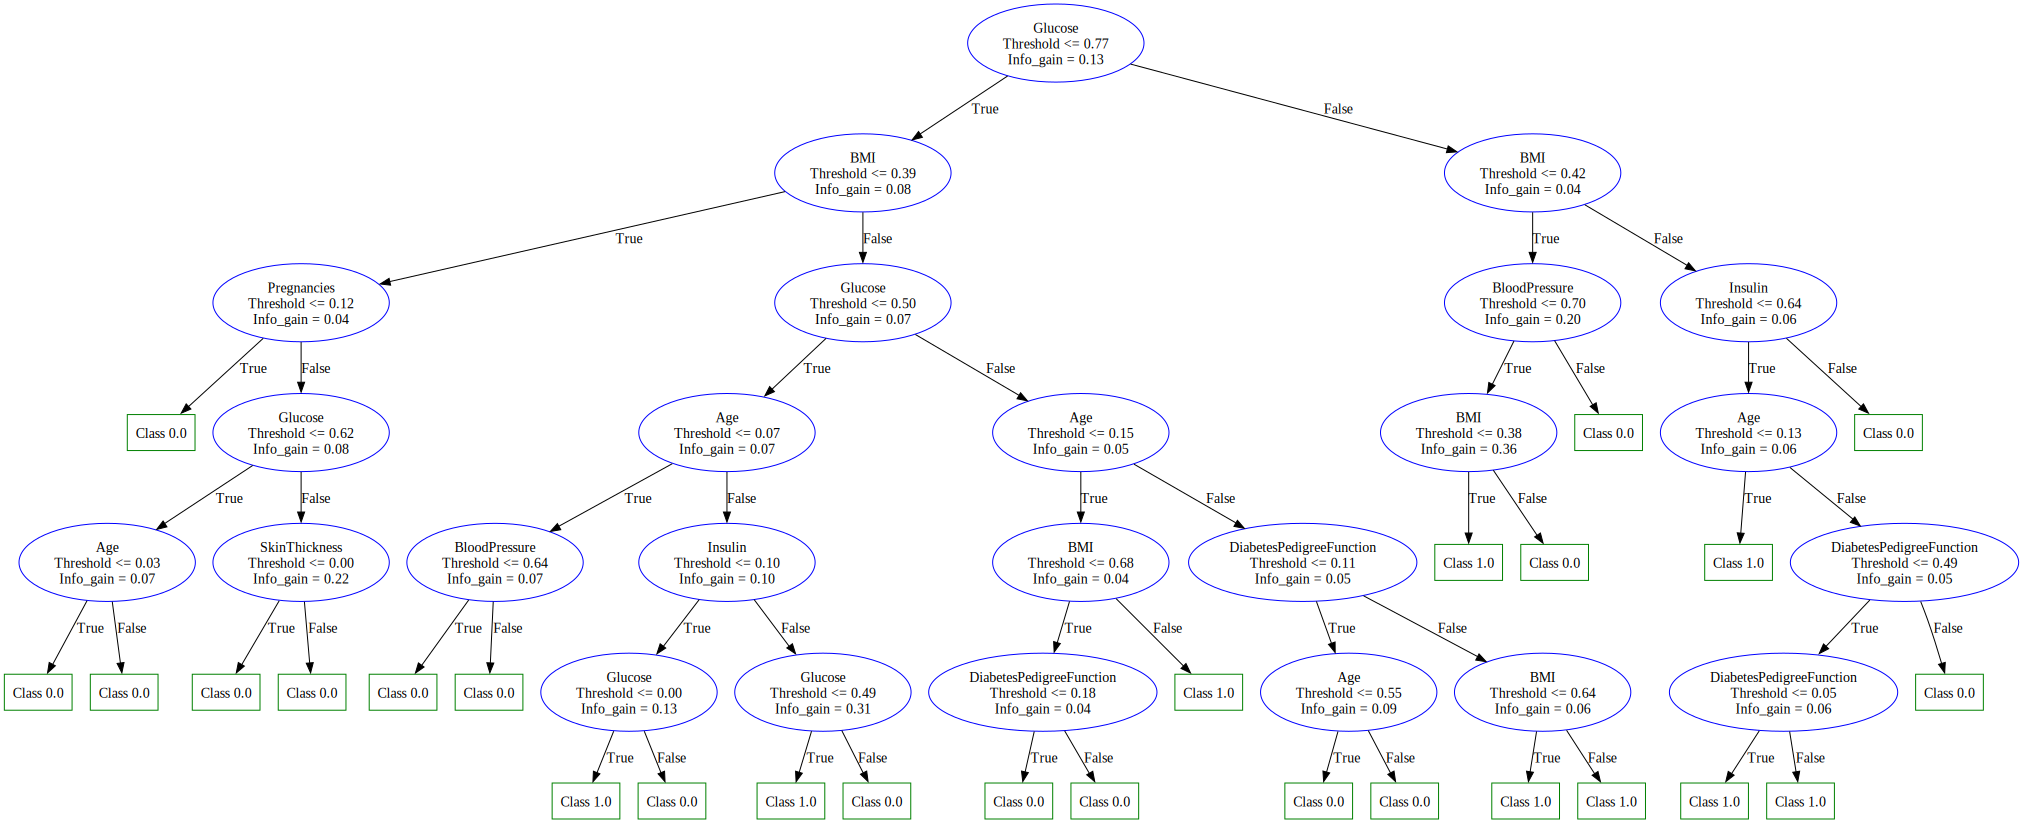

'Decision_tree.pdf'

In [18]:
dot_representation = export_tree_to_dot(classifier.root, feature_names)
graph = graphviz.Source(dot_representation)
display(graph)
graph.render("Decision_tree")
graph.view("Decision_tree")

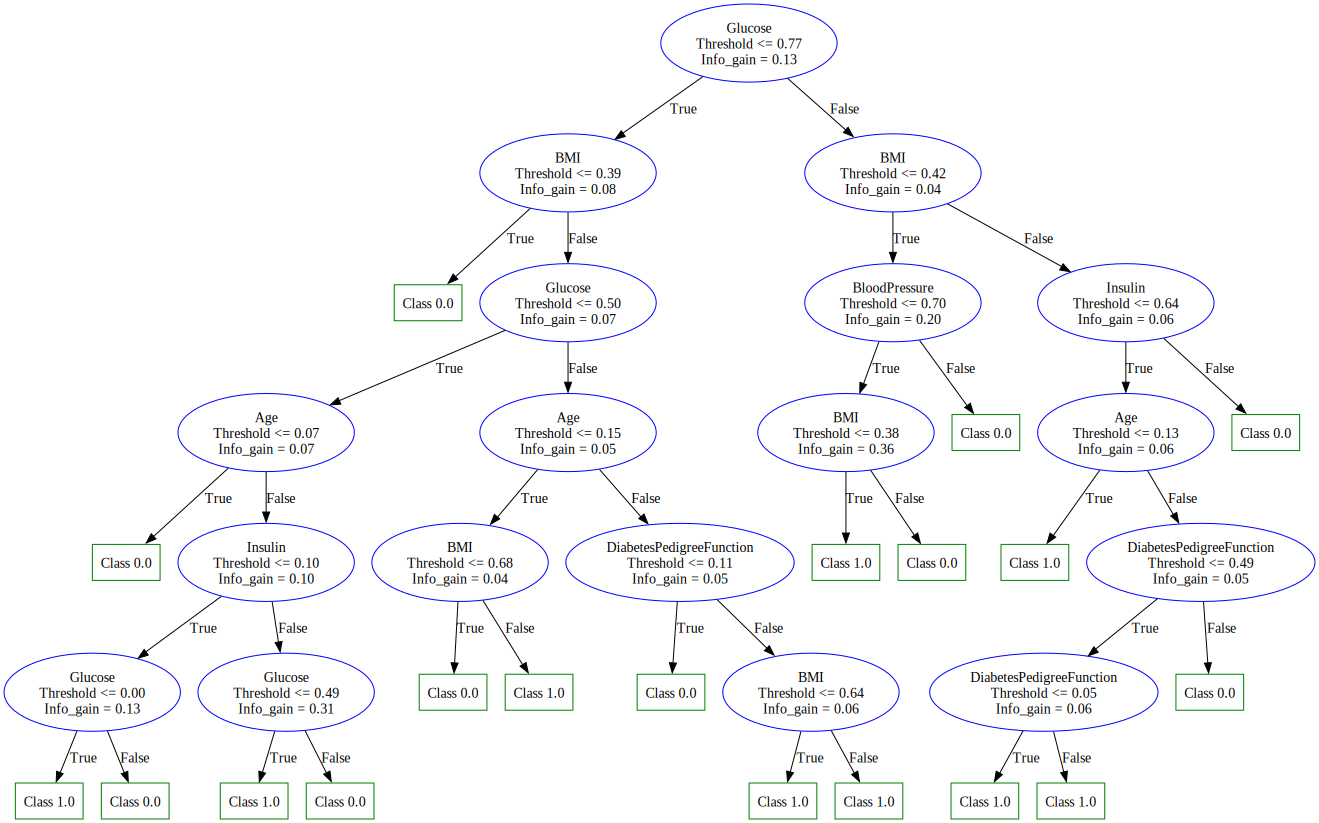

'Decision_tree_prune.pdf'

In [19]:
dot_representation_prune = export_tree_to_dot(classifier_prune.root, feature_names)
graph_prune = graphviz.Source(dot_representation_prune)
display(graph_prune)
graph_prune.render("Decision_tree_prune")
graph_prune.view("Decision_tree_prune")

#### Observation : No. of nodes in the graph were reduced in the Decision Tree implemented with post pruning but the overall accuracy metrics remained same

#### Plotting the variations in accuracy of the Decision Tree with the change of maximum depth

In [20]:
acc_vals_test = []
acc_vals_train = []
depth = list(range(20))

for max_depth in depth:
    model = DecisionTreeClassifier(min_samples_split=10, max_depth=max_depth)
    model.fit(X_train,Y_train)
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)
    acc_vals_train.append(accuracy_score(Y_train, Y_pred_train))
    acc_vals_test.append(accuracy_score(Y_test, Y_pred_test))

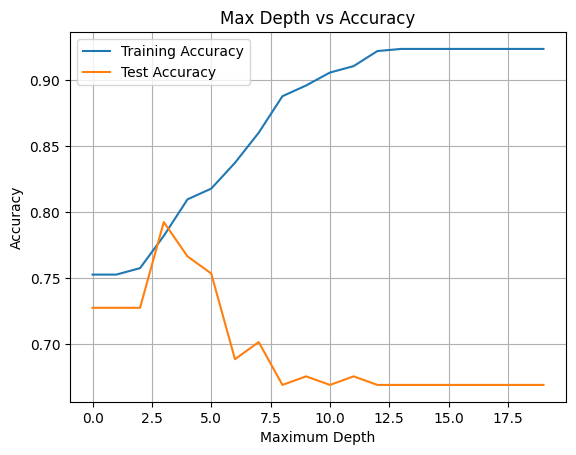

In [22]:
y = range(0, 20)
plt.plot(y, acc_vals_train, label="Training Accuracy")
plt.plot(y, acc_vals_test, label="Test Accuracy")
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Max Depth vs Accuracy')
plt.grid()
plt.legend()
plt.show()